In [1]:
import pandas as pd
import numpy as np

stocks = pd.read_csv("data/stocks_ti.csv")

import warnings

warnings.filterwarnings("ignore")

In [2]:
from utils import add_sentiment_ti

# add ti to sentiment features
stocks = add_sentiment_ti(stocks)


### Classifiers

I'm going to run Logistic Regression, Random Forest, and XGBoost classifiers on the data. Each model will be evaluated on the following datasets:
1. Previous days SPY returns
2. Previous subset plus previous days sector ETFs returns
3. Previous subset plus sentiment scores
4. Data from 2. plus technical indicators
5. Full dataset comprising sector ETFs, sentiment scores, and technical indicators

The previous process will be iterated trying to predict 1 day, 5 day, 13 day and 21 day returns.

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


def plot_all_confusion_matrices(feature_types_dict, title):
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))
    fig.suptitle(title, fontsize=16)

    for i, (feature_type, days_dict) in enumerate(feature_types_dict.items()):
        nons = 0
        for j, (days, results) in enumerate(days_dict.items()):
            if results is None:
                nons += 1
            if results is not None:
                cm = results[1]
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot(
                    ax=axes[i, j - nons],
                    cmap="Blues",
                    values_format=".0f",
                    colorbar=False,
                )
                axes[i, j - nons].set_title(
                    f"Feature type: {feature_type} \n Predicting {days} day(s) return",
                    fontsize=10,
                )

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave some space at the top for the title
    plt.show()

### Input data sequentially

In [8]:
from utils import prep_classifier_data, feature_type_map

fm = feature_type_map(stocks)
columns1 = list(set(fm["spy_returns"]))
columns2 = list(set(fm["returns"]))
columns3 = list(set(fm["returns"] + fm["sentiment"]))
columns4 = list(set(fm["returns"] + fm["technical"]))
columns5 = stocks.columns

# 5 random states on which to run the models
import random

random_states = random.sample(range(int(1e9)), 5)

# dictionary to store tuple of (pred, confusion_matrix, classifier) for each day, for each feature type, for each model
models_key = {
    "logistic_regression": {
        "spy_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 8: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 8: None, 13: None, 21: None},
    },
    "random_forest": {
        "spy_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 8: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 8: None, 13: None, 21: None},
    },
    "xgboost": {
        "spy_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 8: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 8: None, 13: None, 21: None},
    },
    "mlp": {
        "spy_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 8: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 8: None, 13: None, 21: None},
    },
}

y_tests = {
    "spy_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
    "sector_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
    "sector_returns_sentiment": {1: None, 5: None, 8: None, 13: None, 21: None},
    "sector_returns_technical": {1: None, 5: None, 8: None, 13: None, 21: None},
    "all_features": {1: None, 5: None, 8: None, 13: None, 21: None},
}

# loop 5 times to get average results
keys_list = []

for k, rs in enumerate(random_states):
    # loop through each day and each feature type
    for i, day_no in enumerate([1, 8, 21]):
        for j, features in enumerate(
            [columns1, columns2, columns3, columns4, columns5]
        ):
            features_type = [
                "spy_returns",
                "sector_returns",
                "sector_returns_sentiment",
                "sector_returns_technical",
                "all_features",
            ][j]

            # prep data
            X_train, X_test, y_train, y_test = prep_classifier_data(
                stocks[features].copy(), day_no, sequential=True
            )

            if y_tests[features_type][day_no] is None:
                y_tests[features_type][day_no] = y_test

            ## models
            from utils import (
                logistic_regression,
                random_forest_classifier,
                xgboost_classifier,
                mlp_classifier,
            )

            # logistic regression
            print(f"Logistic Regression on {day_no} day(s) with {features_type}...")
            models_key["logistic_regression"][features_type][
                day_no
            ] = logistic_regression(X_train, X_test, y_train, y_test, random_state=rs)

            # random forest
            print(f"Random Forest on {day_no} day(s) with {features_type}...")
            models_key["random_forest"][features_type][
                day_no
            ] = random_forest_classifier(
                X_train, X_test, y_train, y_test, random_state=rs
            )

            # xgboost
            print(f"XGBoost on {day_no} day(s) with {features_type}...")
            models_key["xgboost"][features_type][day_no] = xgboost_classifier(
                X_train, X_test, y_train, y_test, random_state=rs
            )

            # mlp
            print(f"MLP on {day_no} day(s) with {features_type}...")
            models_key["mlp"][features_type][day_no] = mlp_classifier(
                X_train, X_test, y_train, y_test, random_state=rs
            )
    keys_list.append((rs, models_key, y_tests))

Logistic Regression on 1 day(s) with spy_returns...
Accuracy: 0.59
Random Forest on 1 day(s) with spy_returns...
Accuracy: 0.53
XGBoost on 1 day(s) with spy_returns...
Accuracy: 0.52
MLP on 1 day(s) with spy_returns...
Accuracy: 0.50
Logistic Regression on 1 day(s) with sector_returns...
Accuracy: 0.58
Random Forest on 1 day(s) with sector_returns...
Accuracy: 0.46
XGBoost on 1 day(s) with sector_returns...
Accuracy: 0.55
MLP on 1 day(s) with sector_returns...
Accuracy: 0.49
Logistic Regression on 1 day(s) with sector_returns_sentiment...
Accuracy: 0.59
Random Forest on 1 day(s) with sector_returns_sentiment...
Accuracy: 0.50
XGBoost on 1 day(s) with sector_returns_sentiment...
Accuracy: 0.48
MLP on 1 day(s) with sector_returns_sentiment...
Accuracy: 0.51
Logistic Regression on 1 day(s) with sector_returns_technical...
Accuracy: 0.47
Random Forest on 1 day(s) with sector_returns_technical...
Accuracy: 0.46
XGBoost on 1 day(s) with sector_returns_technical...
Accuracy: 0.45
MLP on 1 day

In [29]:
## get losses
clf = models_key["mlp"]["all_features"][21][2]
y_pred = models_key["mlp"]["all_features"][21][0]

from sklearn.metrics import log_loss

log_loss(y_tests["all_features"][21], (y_pred > 0.5).astype(int))


13.828993545212294

In [30]:
clf = models_key["logistic_regression"]["all_features"][21][2]
y_pred = models_key["logistic_regression"]["all_features"][21][0]

log_loss(y_tests["all_features"][21], (y_pred > 0.5).astype(int))


16.771332597385122

In [35]:
clf = models_key["xgboost"]["all_features"][21][2]
y_pred = models_key["xgboost"]["all_features"][21][0]

log_loss(y_tests["all_features"][21], (y_pred > 0.5).astype(int))


17.801151265645615

In [36]:
clf = models_key["random_forest"]["all_features"][21][2]
y_pred = models_key["random_forest"]["all_features"][21][0]

log_loss(y_tests["all_features"][21], (y_pred > 0.5).astype(int))


16.918449549993763

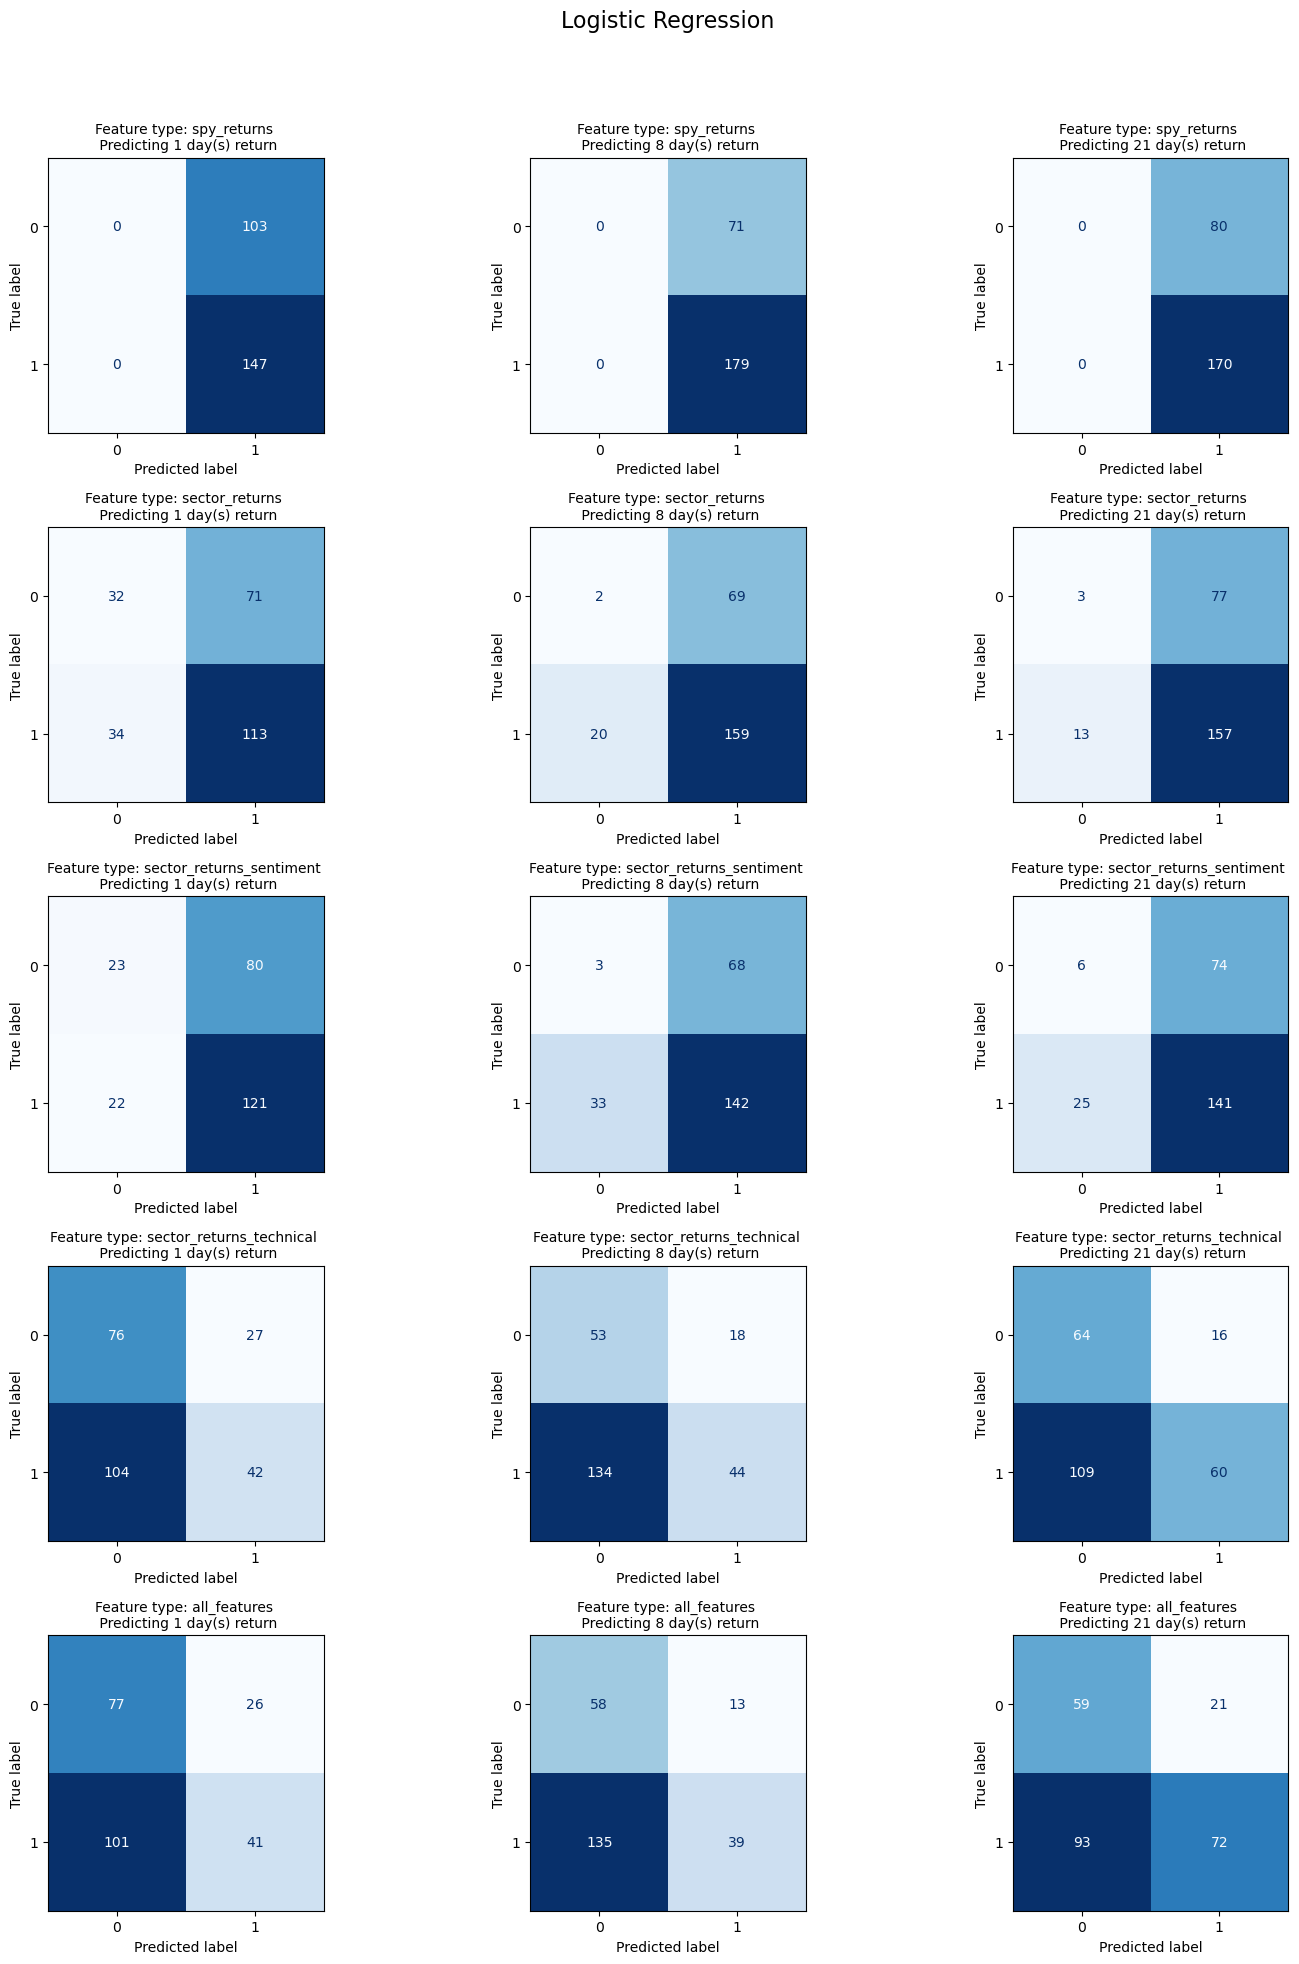

In [23]:
plot_all_confusion_matrices(models_key["logistic_regression"], "Logistic Regression")

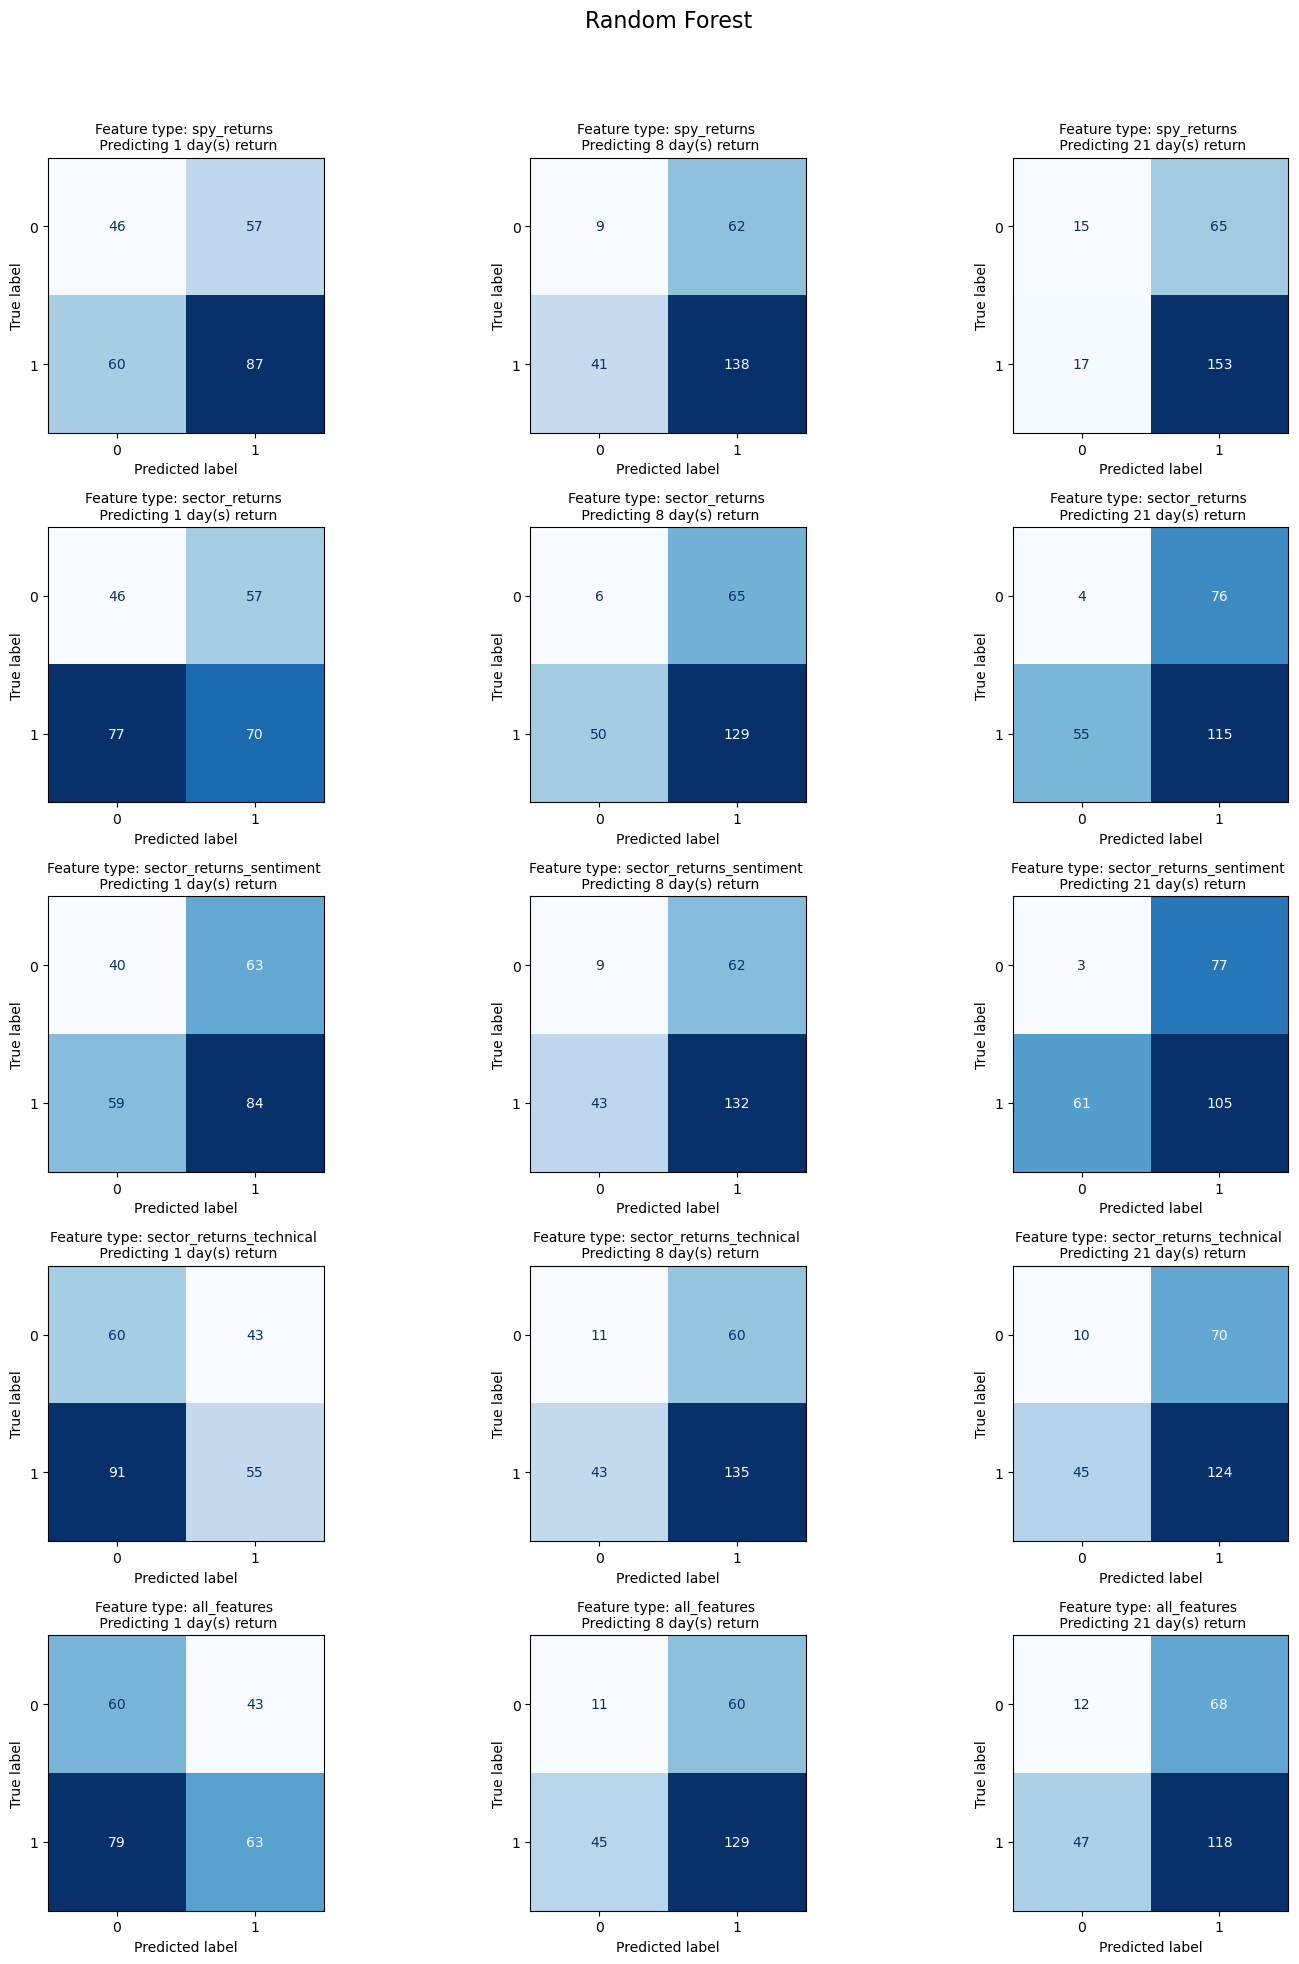

In [24]:
plot_all_confusion_matrices(models_key["random_forest"], "Random Forest")

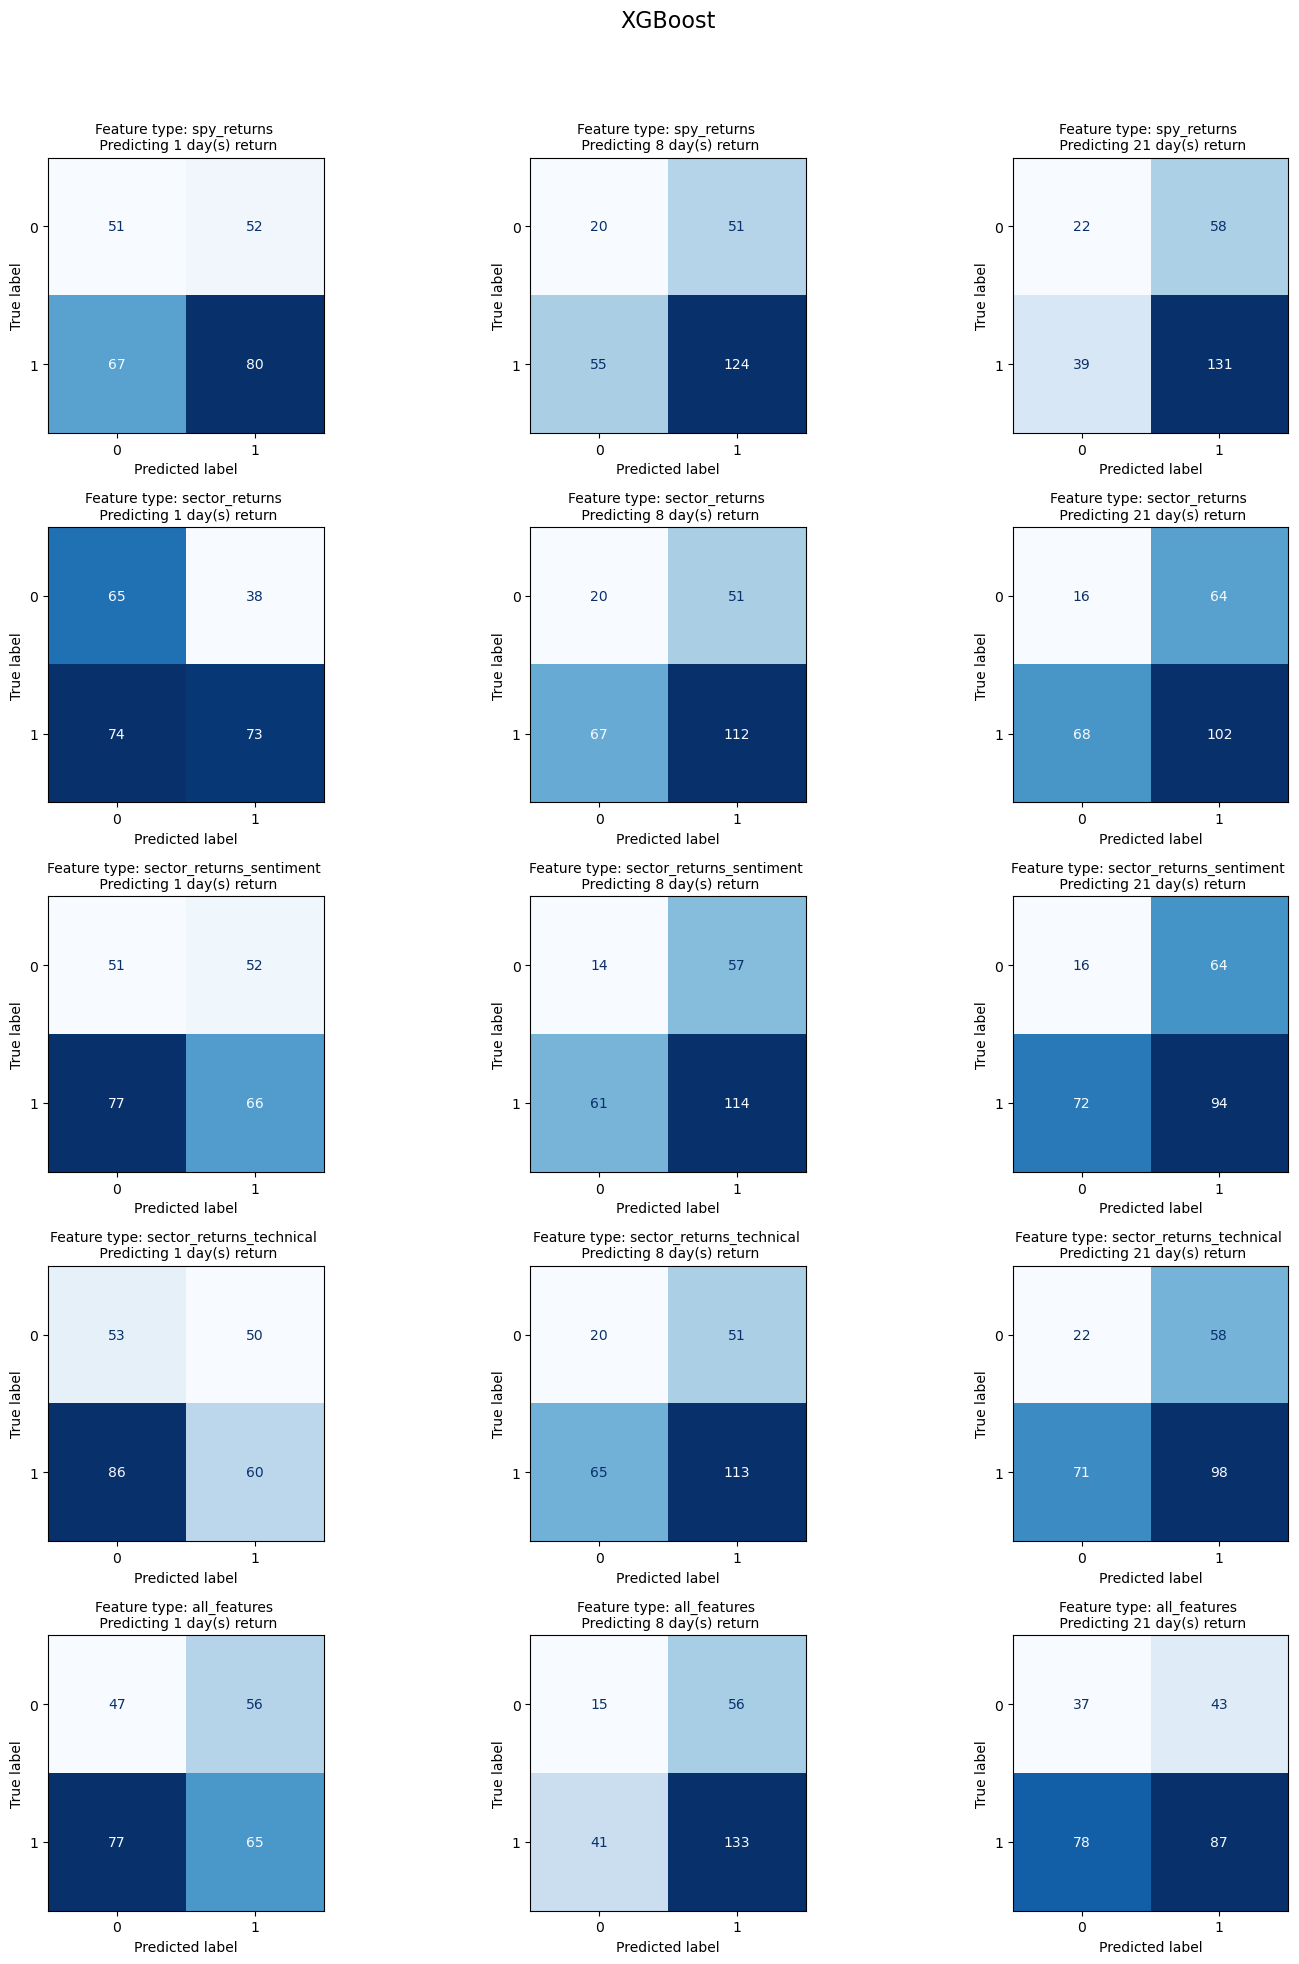

In [25]:
plot_all_confusion_matrices(models_key["xgboost"], "XGBoost")

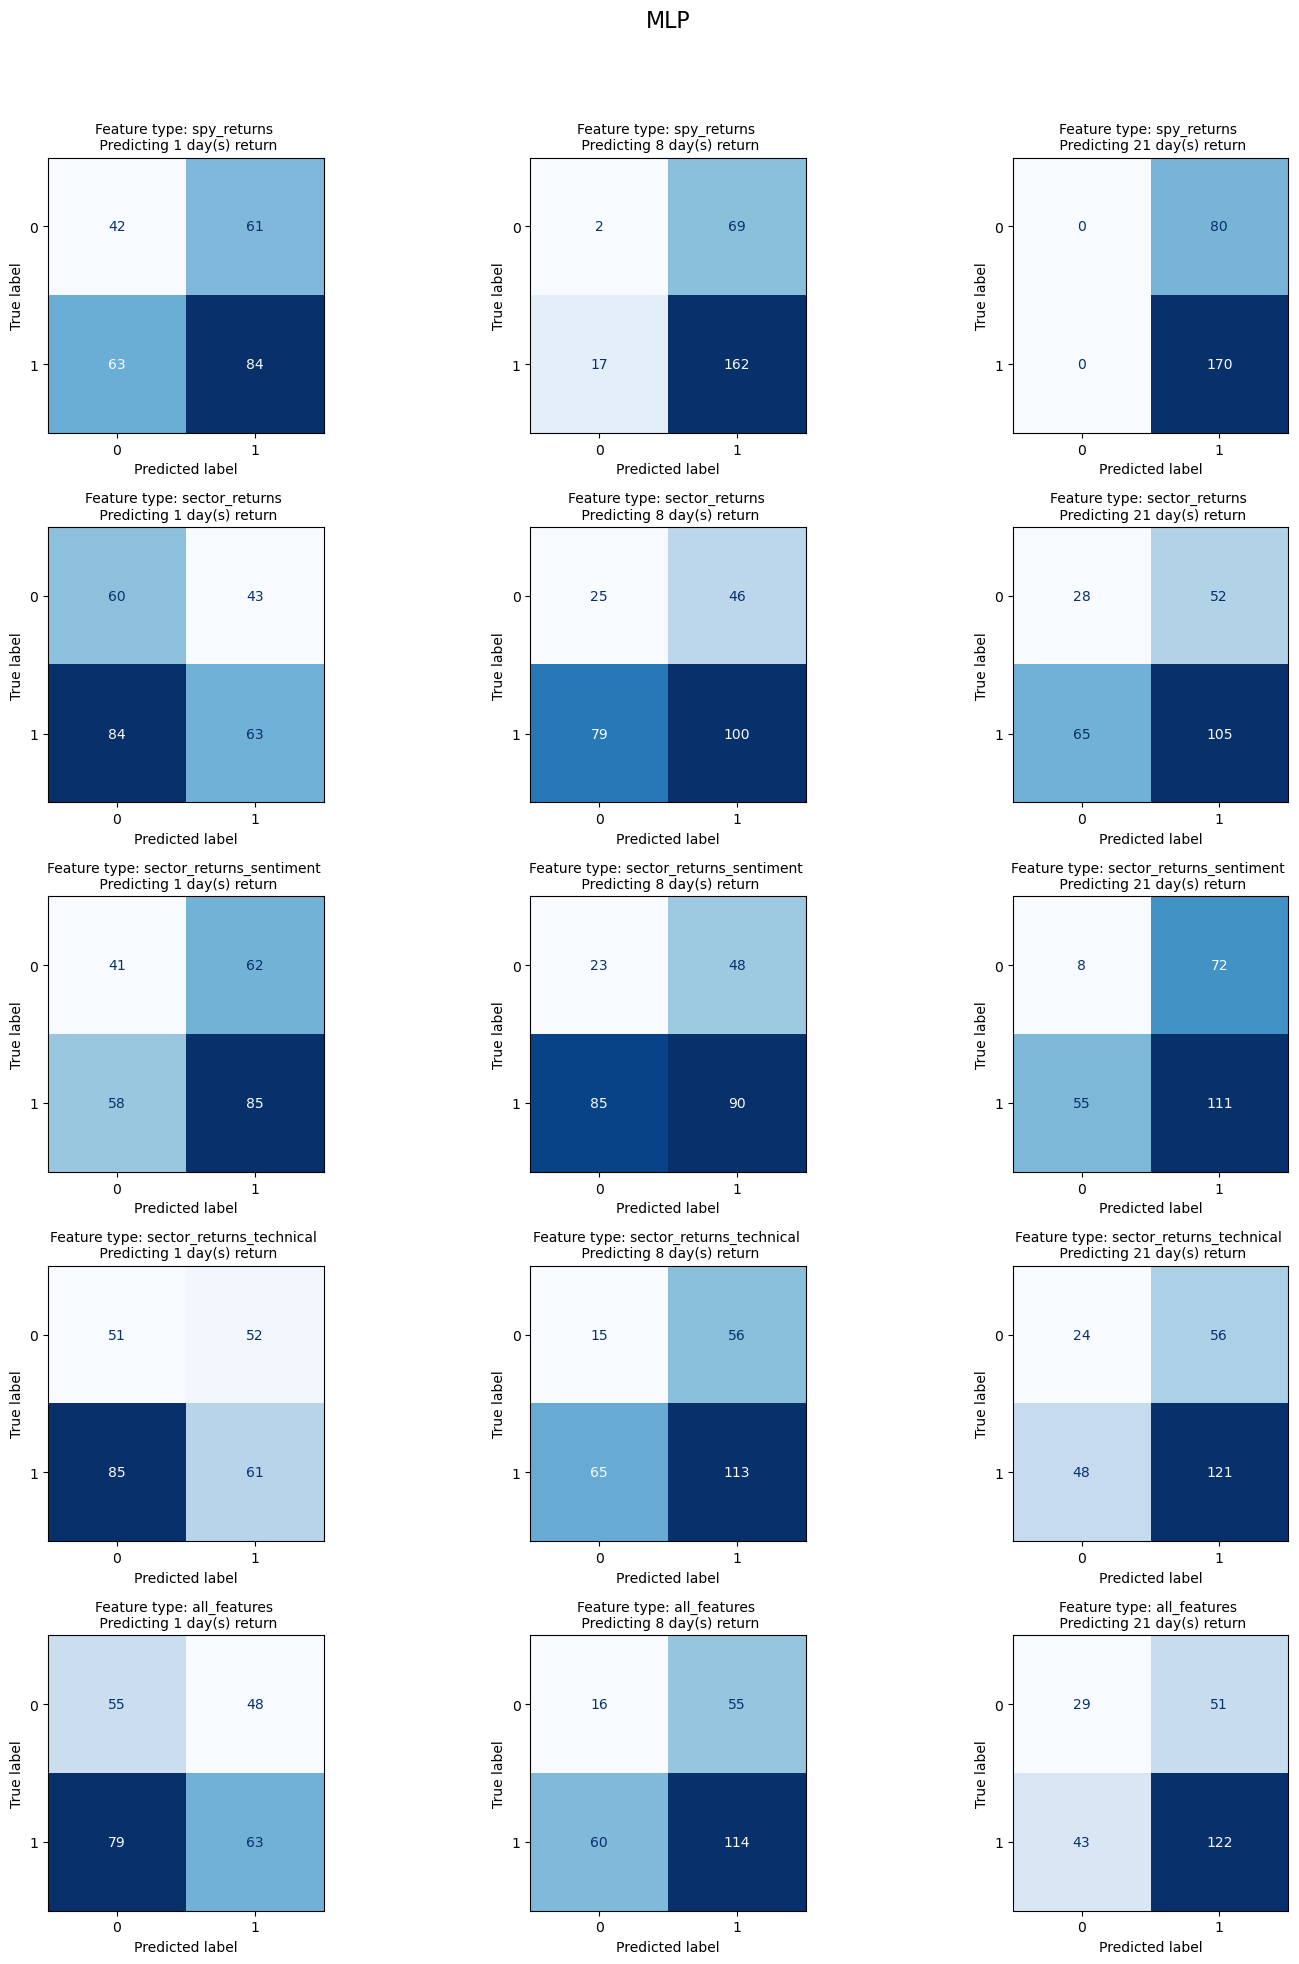

In [26]:
plot_all_confusion_matrices(models_key["mlp"], "MLP")

In [ ]:
## feature importance
# random forest
from utils import (
    plot_feature_importance,
    prep_classifier_data,
    random_forest_classifier,
)

X_train, X_test, y_train, y_test = prep_classifier_data(
    stocks.copy(),
    21,
    sequential=False,
)

rf = random_forest_classifier(X_train, X_test, y_train, y_test)[2]

plot_feature_importance(rf, X_train, 21)

In [15]:
feature_importance = rf.feature_importances_
feature_names = np.arange(X_train.shape[1])
sorted_idx = feature_importance.argsort()[::-1]
stocks.columns[sorted_idx]

Index(['XLV_OPEN', 'XLU_ewm_log_ret_1d', 'XLU_macd_8d_slope', 'XBI_OPEN',
       'XLP_rsi_8d_slope', 'XLY_OPEN', 'XLK_ewm_log_ret_1d',
       'XOP_rsi_8d_slope', 'DATE', 'SPY_ewm_log_ret_1d',
       ...
       'SPY_ewm_log_ret_13d', 'XOP_ewm_log_ret_13d', 'SPY_macd_13d_slope',
       'XLI_log_ret_21d', 'XLI_rsi_13d_slope', 'XLE_HIGH',
       'SPY_3M IMPLIED VOL', 'SPY_log_ret_13d', 'XBI_HIGH', 'XRT_LOW'],
      dtype='object', length=420)

In [19]:
stocks.drop(columns=["DATE"]).columns[sorted_idx]

Index(['XLV_SHORT INTEREST RATIO', 'XLU_ewm_log_ret_21d', 'XLU_macd_sig',
       'XBI_SHORT INTEREST RATIO', 'XLU_3M IMPLIED VOL',
       'XLY_SHORT INTEREST RATIO', 'XLK_ewm_log_ret_21d', 'XRT_3M IMPLIED VOL',
       'SPY_3M IMPLIED VOL', 'SPY_ewm_log_ret_21d',
       ...
       'SPY_ewm_log_ret_1d', 'XOP_ewm_log_ret_1d', 'SPY_macd_1d_slope',
       'XLI_log_ret_3d', 'XLI_rsi_1d_slope', 'XLE_LOW', 'SPY_HIGH',
       'SPY_log_ret_1d', 'XBI_LOW', 'XRT_OPEN'],
      dtype='object', length=420)

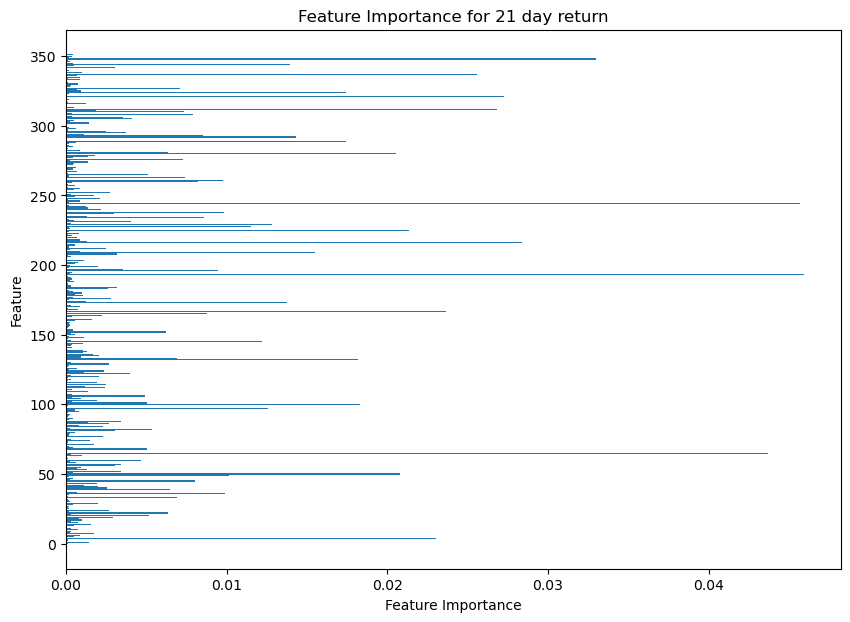

In [15]:
from utils import plot_feature_importance

plot_feature_importance(xgb, X_train, 21)

In [16]:
feature_importance = xgb.feature_importances_
feature_names = np.arange(X_train.shape[1])
sorted_idx = feature_importance.argsort()[::-1]
stocks.drop(columns=["DATE"]).columns[sorted_idx]

Index(['XLP_OPEN', 'XLU_ivol_8d_slope', 'XBI_macd_3d_slope',
       'XOP_ewm_log_ret_1d', 'XLP_macd_21d_slope', 'XLY_log_ret_13d',
       'XLY_ewm_log_ret_3d', 'XLY_rsi_1d_slope', 'XLK_ivol_5d_slope',
       'SPY_SHORT INTEREST RATIO',
       ...
       'XLI_macd_21d_slope', 'SPY_ivol_1d_slope', 'XLV_rsi_21d_slope',
       'XLP_ivol_3d_slope', 'XLE_3M IMPLIED VOL', 'XLY_macd_5d_slope',
       'XLK_log_ret_3d', 'XLE_rsi_13d_slope', 'XLU_ewm_log_ret_3d', 'XLV_LOW'],
      dtype='object', length=352)

In [17]:
stocks.drop(columns=["DATE"]).columns[sorted_idx[:50]]

Index(['XLP_OPEN', 'XLU_ivol_8d_slope', 'XBI_macd_3d_slope',
       'XOP_ewm_log_ret_1d', 'XLP_macd_21d_slope', 'XLY_log_ret_13d',
       'XLY_ewm_log_ret_3d', 'XLY_rsi_1d_slope', 'XLK_ivol_5d_slope',
       'SPY_SHORT INTEREST RATIO', 'XLP_rsi_3d_slope', 'XBI_ivol_1d_slope',
       'XLV_ivol_3d_slope', 'XLE_macd_13d_slope', 'XLI_log_ret_1d', 'XLV_macd',
       'XLY_log_ret_3d', 'XLP_log_ret_21d', 'XLV_macd_21d_slope', 'XOP_LOW',
       'XLK_log_ret_5d', 'XLU_HIGH', 'XLE_log_ret_5d', 'XLI_rsi',
       'XLU_3M IMPLIED VOL', 'XBI_ivol_13d_slope', 'SPY_rsi_5d_slope',
       'XLU_ewm_log_ret_8d', 'XLU_rsi_1d_slope', 'XLP_ewm_log_ret_1d',
       'XLK_ivol_21d_slope', 'XLU_ewm_log_ret_1d', 'XLV_macd_3d_slope',
       'XLU_rsi_13d_slope', 'XBI_ewm_log_ret_21d', 'XLY_SHORT INTEREST RATIO',
       'XLU_rsi_3d_slope', 'XLY_ewm_log_ret_1d', 'XLV_ewm_log_ret_8d',
       'XLY_macd', 'XLI_log_ret_21d', 'SPY_rsi_1d_slope', 'XBI_HIGH',
       'XLV_ivol_5d_slope', 'SPY_log_ret_8d', 'XLK_3M IMPLIED VOL'

Add technical indicators for sentiment